In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from tqdm import tqdm
import os

# Import modules
from model import VAE_WGAN
from dataset import get_data_loaders

In [2]:
# CONFIGURATION
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "vae_wgan_final.pth"
RESULTS_DIR = "results_latent"
Z_DIM = 128 # Must match your model definition
os.makedirs(RESULTS_DIR, exist_ok=True)

In [3]:
def extract_latent_vectors(model, loader):
    """
    Passes data through Encoder to get 'mu' (latent vectors).
    Returns numpy array of shape [N, Z_DIM] and labels [N].
    """
    model.eval()
    z_list = []
    labels_list = []

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Extracting Latent Vectors"):
            imgs = imgs.to(DEVICE)

            # Get the Mean Vector (mu) from the Encoder
            mu, _ = model.encoder(imgs)

            z_list.append(mu.cpu().numpy())
            labels_list.append(labels.numpy())

    return np.concatenate(z_list, axis=0), np.concatenate(labels_list, axis=0)

In [4]:
print(f"--- Latent Space Anomaly Detection ---")

# 1. Load Data
# We need TRAIN loader (to fit GMM) and TEST loader (to evaluate)
train_loader, test_loader = get_data_loaders('modis_dataset_brazil', batch_size=BATCH_SIZE)

--- Latent Space Anomaly Detection ---
Total Normal: 9298
Total Fire: 9299
--- Split Summary ---
Train Set (Normal Only): 7438 images
Test Set (Normal):       1860 images
Test Set (Fire):         1860 images
Total Test Set:          3720 images


In [5]:
# 2. Load Model
model = VAE_WGAN().to(DEVICE)
if not os.path.exists(MODEL_PATH):
    print("Error: Model not found.")
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
print("Model loaded.")

Model loaded.


In [6]:
# 3. Extract Latent Vectors for Training Data (Normal Only)
print("Processing Training Data (Normal Forests)...")
z_train, _ = extract_latent_vectors(model, train_loader)
print(f"Training Vectors shape: {z_train.shape}")

Processing Training Data (Normal Forests)...


Extracting Latent Vectors: 100%|██████████| 117/117 [00:11<00:00, 10.12it/s]

Training Vectors shape: (7438, 128)


In [7]:
# 4. Fit Gaussian Mixture Model (GMM)
# We try to find the 'shape' of the Normal data in latent space
print("Fitting GMM to Normal Data (this might take a minute)...")
# n_components=5 allows for 5 different 'types' of forests (dense, sparse, etc.)
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42, reg_covar=1e-4)
gmm.fit(z_train)
print("GMM Fit Complete.")

Fitting GMM to Normal Data (this might take a minute)...
GMM Fit Complete.


In [8]:
# 5. Extract Latent Vectors for Test Data (Fire + Normal)
print("\nProcessing Test Data...")
z_test, labels_test = extract_latent_vectors(model, test_loader)


Processing Test Data...


Extracting Latent Vectors: 100%|██████████| 59/59 [00:09<00:00,  6.19it/s]


In [9]:
# 6. Calculate Anomaly Score (Negative Log Likelihood)
# score_samples returns log-likelihood. Higher = More Normal.
# We want Anomaly Score. So we take negative.
log_likelihood = gmm.score_samples(z_test)
anomaly_scores = -log_likelihood

In [10]:
# 7. Evaluate Performance
fpr, tpr, thresholds = roc_curve(labels_test, anomaly_scores)
roc_auc = auc(fpr, tpr)

print(f"\n================ RESULTS ================")
print(f"Latent AUC Score: {roc_auc:.4f}")


================ RESULTS ================
Latent AUC Score: 0.7406


Saved plot to results_latent/latent_evaluation.png


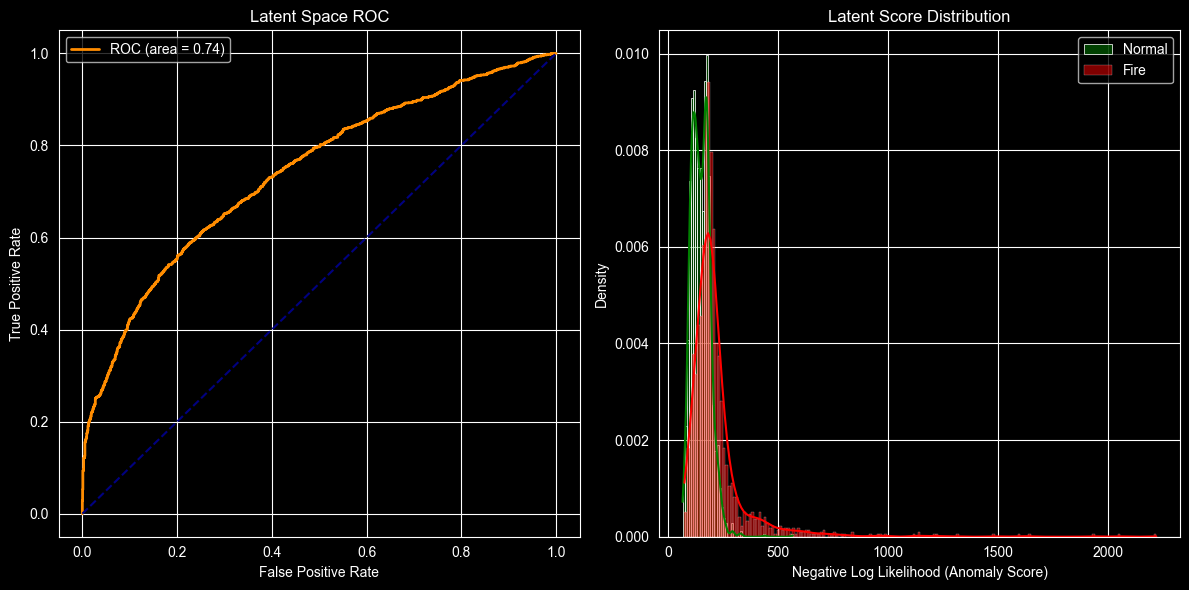

In [11]:
# 8. Visualization
plt.figure(figsize=(12, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Latent Space ROC')
plt.legend()

# Histogram
plt.subplot(1, 2, 2)
sns.histplot(anomaly_scores[labels_test==0], color='green', label='Normal', kde=True, stat="density", alpha=0.5)
sns.histplot(anomaly_scores[labels_test==1], color='red', label='Fire', kde=True, stat="density", alpha=0.5)
plt.title('Latent Score Distribution')
plt.xlabel('Negative Log Likelihood (Anomaly Score)')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'latent_evaluation.png'))
print(f"Saved plot to {RESULTS_DIR}/latent_evaluation.png")